In [1]:
import os.path
import numpy as np
import matplotlib.pyplot as plt
import scipy
import refnx
from refnx.dataset import ReflectDataset, Data1D
from refnx.analysis import Transform, CurveFitter, Objective, Model, Parameter, GlobalObjective
from refnx.reflect import SLD, Slab, ReflectModel#, LipidLeaflet
from refnx.reflect import LipidLeaflet #as LipidLeafletNoProtein
# from sepObjectiveGO import getObjective as gO
# import make_sim_data as msd
# import lipidBilayerAsGiven.SLD_maker 
import data_in as di
# from protein.ProteinBuiltOnLL3 import LipidLeafletWithProtien as LipidLeaflet
from protein.protrusion2 import Protrusion

from refnx._lib import flatten
from refnx._lib import unique as f_unique

print('refnx: %s\nscipy: %s\nnumpy: %s' % (refnx.version.version,
                   scipy.version.version, np.version.version))
%matplotlib inline
SEED = 12345

refnx: 0.1.9
scipy: 1.3.0
numpy: 1.16.4


csv
cvs-collecting


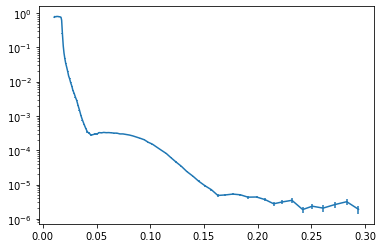

In [2]:
dataD2o = Data1D(data=di.data_in("lipidBilayerData/54696_97_edit.txt"))
dataD2o.name="d2o"
# dataPmw = Data1D(data=di.data_in("lipidBilayerData/54699_00_edit.txt"))
# dataPmw.name="pmw"

# dataAcmw = Data1D(data=di.data_in("protein/54613_14edit.txt"))
# dataAcmw.name="acm"
# dataPmw = Data1D(data=di.data_in("protein/54616_17edit.txt"))
# dataPmw.name="pmw"
# dataD2o = Data1D(data=di.data_in("protein/10_11_d2o.txt"))
# dataD2o.name="d2o"
# plt.errorbar(dataAcmw.data[0],dataAcmw.data[1],dataAcmw.data[2])
# plt.errorbar(dataPmw.data[0],dataPmw.data[1],dataPmw.data[2])
plt.errorbar(dataD2o.data[0],dataD2o.data[1],dataD2o.data[2])
plt.yscale("log")
plt.show()

In [3]:
name = "bilayer"

d2o = SLD(6.34, "D2O")
pmw = SLD(2.35, "Protein Matched Water")
# acmw = SLD(0.00, "ACMW")
air = SLD(0.00, "Air")

d2o.real.setp(vary=True, bounds=(5.35, 6.35)) # bounds=(5.9, 6.35))
pmw.real.setp(vary=True, bounds=(1.35, 3.35))
# acmw.real.setp(vary=True, bounds=(-0.56, 1))

apm = Parameter(value=50, name='%s - area_per_molecule' % name,
                bounds=(25, 100), vary=True)

#Define all the neutron b's
bc = 0.6646e-4  #Carbon
bo = 0.5804e-4  #Oxygen
bh = -0.3739e-4 #Hydrogen
bp = 0.513e-4   #Phosphorus
bn = 0.936e-4   #Nitrogen
bd = 0.6671e-4  #Deuterium

#Formulae of the molecule sections...
CH2 = (1*bc) + (2*bh)
CH = (1*bc) + (1*bh)
CH3 = (1*bc) + (3*bh)
D2O = (2*bd) + (1*bo)
H2O = (2*bh) + (1*bo)

# Calculate mole fraction of D2O from the bulk SLD..
# d2o_molfr = (1/D2O-H2O)*(contrast*27.64)-H2O
# wMol = (d2o_molfr * D2O) + ((1-d2o_molfr)*H2O)

#sum b's of all the different fragments
b_tails = Parameter(value=(28*CH2) + (2*CH) + (2*CH3),
                       name='%s - b_tails_real' % name)

sum_popc_heads = (8*bo) + (1*bp) + (1*bn) + (2*bc) + (4*CH2) + (3*CH3) + (1*CH)
sum_popg_heads = (10*bo) + (1*bp) + (2*bc) + (4*CH2) + (2*CH) + (2*bh)
b_heads = Parameter(value=(3*(sum_popc_heads) + (sum_popg_heads))/4,
                        name='%s - b_heads_real' % name)

#monolayer compositions
#sum_m_tails = (34*CH2) + (2*CH3);
#sum_m_heads = (1*bn) + (2*CH3) + (Waters_per_headD * wMol);

#volumes of each fragment
vCH2 = 27.7
nCH2 = 30
vCH3 = 54.6
vm_tails = Parameter(value=(nCH2 * vCH2) + (2 * vCH3),
            name='%s - volume_tails' % name) #
vm_heads = Parameter(value=331,
            name='%s - volume_heads' % name)  #
vm_water = Parameter(value=29.7,
            name='%s - water_vm' % name)

#thickness
thickness_tails = Parameter(11, # 6., #value=vm_tails.value/apm.value,
            name='%s - thickness_tails' % name,# vary=False)
            bounds=(1,30),  #3, #(1-0.75)*vm_tails.value/apm.value,
                      #9), #(1+0.75)*vm_tails.value/apm.value),
               vary=True)
thickness_heads = Parameter(value= 6, #11., #vm_heads.value/apm.value,
            name='%s - thickness_heads' % name,# vary=False)
            bounds=(1,30),  #  9, #(1-0.75)*vm_heads.value/apm.value,
                      # 20), #(1+0.75)*vm_heads.value/apm.value),
               vary=True)

rough_head_tail = Parameter(value=2,
            name='%s - roughs' % name,
            bounds=(0,10), vary=True)

rough_top = Parameter(value=2,
            name='%s - roughs' % name,
            bounds=(0,10), vary=True)
# rough_bot = rough_top
# rough_head_ = Parameter(value=2.0,
#             name='%s - rough_bot' % name,
#             bounds=(0,10), vary=True)

waters_head_frac = Parameter(
            value=0.25,
            name="{} - Waters Head fraction".format(name),
            bounds=(0, 0.5), vary=True)

waters_tail_frac = Parameter(
            value=0.25,
            name="{} - Waters Tail fraction".format(name),
            bounds=(0, 0.5), vary=True)

# b_mscl = Parameter(
#             value= ,
#             name="{} - b_protein_real".format(name),
#             vary=False)

vm_mscl = Parameter(
            value=74937.5 + 19749,
            name="{} - volume_protein".format(name),
            vary=False)

PLRatio = Parameter(
            value= 0.75,
            name="{} - ratio protein to bilayer".format(name),
            bounds=(0, 1),vary=True)


In [4]:
# apm, b_heads, vm_heads, thickness_heads
# b_tails, vm_tails, thickness_tails, rough_head_tail
# rough_preceding_mono, head_solvent

# apm, b_heads, vm_heads, thickness_heads,
#  b_tails, vm_tails, thickness_tails, rough_head_tail,
#  rough_preceding_mono,
#  waters_head_frac, waters_tail_frac,
#  vm_mscl, PLRatio,
#  head_solvent=None, tail_solvent=None,
#  reverse_monolayer=False, name=''

# head_solvent_d2o = SLD(6.07, "D2O in bilayer")
# head_solvent_d2o.real.setp(6.07, vary=True, bounds=(5.35, 6.35))
upper_lipid_d2o = LipidLeaflet(apm, b_heads, vm_heads, thickness_heads,
    b_tails, vm_tails, thickness_tails, rough_top, rough_top,
#     waters_head_frac, waters_tail_frac,
   # vm_mscl, PLRatio,
                               d2o, d2o,
    reverse_monolayer=False, name="upper_lipid_d2o")

lower_lipid_d2o = LipidLeaflet(apm, b_heads, vm_heads, thickness_heads,
    b_tails, vm_tails, thickness_tails, rough_top, rough_top,
#     waters_head_frac, waters_tail_frac,
    #vm_mscl, PLRatio,
                               d2o, d2o,
    reverse_monolayer=True, name="lower_lipid_d2o")


# # head_solvent_pmw = SLD(2.35, "Protein Matched Water in bilayer")
# # head_solvent_pmw.real.setp(2.34, vary=True, bounds=(1.35, 3.35))
# upper_lipid_pmw = LipidLeaflet(apm, b_heads, vm_heads, thickness_heads,
#     b_tails, vm_tails, thickness_tails, rough_top, rough_top,
# #     waters_head_frac, waters_tail_frac,
#     #vm_mscl, PLRatio,
#                                pmw, pmw,
#     reverse_monolayer=False, name="upper_lipid_pmw")

# lower_lipid_pmw = LipidLeaflet(apm, b_heads, vm_heads, thickness_heads,
#     b_tails, vm_tails, thickness_tails, rough_top, rough_top,
# #     waters_head_frac, waters_tail_frac,
#    # vm_mscl, PLRatio,
#                                pmw, pmw,
#     reverse_monolayer=True, name="lower_lipid_pmw")


# # upper_lipid_acmw = LipidLeaflet(apm, b_heads, vm_heads, thickness_heads,
# #     b_tails, vm_tails, thickness_tails, rough_top, rough_top,
# # #     waters_head_frac, waters_tail_frac,
# #     #vm_mscl, PLRatio,
# #                                 acmw, acmw,
# #     reverse_monolayer=False, name="upper_lipid_acmw")

# # lower_lipid_acmw = LipidLeaflet(apm, b_heads, vm_heads, thickness_heads,
# #     b_tails, vm_tails, thickness_tails, rough_top, rough_top,
# # #     waters_head_frac, waters_tail_frac,
# #     #vm_mscl, PLRatio,
# #                                 acmw, acmw,
# #     reverse_monolayer=True, name="lower_lipid_acmw")

In [5]:
# name_m = "mono, dodab"
# APMD = Parameter(value=48, name='%s - area_per_molecule' % name_m,
#         bounds=(40,200), vary=True)

# # monolayer compositions
# m_tails = Parameter(value=(34*CH2) + (2*CH3),
#             name='%s - b_tails_real' % name_m)
# m_heads = Parameter(value=(1*bn) + (2*CH3),
#             name='%s - b_heads_real' % name_m)

# # monolayer volumes
# vm_m_tails = Parameter(value=vCH2*36,
#             name='%s - volume_tails' % name_m)
# vm_m_heads = Parameter(value=54.6,
#             name='%s - volume_heads' % name_m)

# # monolayer thicknesses
# tail_thick_m = Parameter(value=vm_m_tails.value / APMD.value,
#             name='%s - thickness_tails' % name_m,
#             bounds=(1,#(1-0.75)*vm_m_tails.value / APMD.value,
#                     30),#(1+0.75)*vm_m_tails.value / APMD.value),
#                vary=True)
# head_thick_m = Parameter(value=vm_m_heads.value / APMD.value,
#             name='%s - thickness heads' % name_m,
#             bounds=(1,#(1-0.75)*vm_m_heads.value / APMD.value,
#                     30),#(1+0.75)*vm_m_heads.value / APMD.value),
#                vary=True)

# roughness_m =  Parameter(value=5.8,
#             name='%s - roughness' % name_m,
#             bounds=(0,10), vary=True)

In [6]:
# firstlayerd = SLD(0, "d20 first layer")
# firstlayerd.real.setp(vary=True, bounds=(-1, 6.35))
# firstlayerp = SLD(0, "pmw first layer")
# firstlayerp.real.setp(vary=True, bounds=(-1, 6.35))
# firstlayera = SLD(0, "acmw first layer")
# firstlayera.real.setp(vary=True, bounds=(-1, 6.35))
# secondlayerd = SLD(0, "d20 second layer")
# secondlayerd.real.setp(vary=True, bounds=(-1, 6.35))
# secondlayerp = SLD(0, "pmw second layer")
# secondlayerp.real.setp(vary=True, bounds=(-1, 6.35))
# secondlayera = SLD(0, "acmw second layer")
# secondlayera.real.setp(vary=True, bounds=(-1, 6.35))

# m_air_in_tail = air
# m_head_solvent_d2o = d2o
# m_head_solvent_pmw = pmw
# # m_head_solvent_acmw = acmw
# dodab_solv = SLD(0.00, "dodab solv in tail")
# dodab_solv.real.setp(vary=True, bounds=(-1, 6.35))

# dodab_d2o = LipidLeaflet(apm=APMD, b_heads=m_heads, vm_heads=vm_m_heads,
# thickness_heads=head_thick_m, b_tails=m_tails, vm_tails=vm_m_tails,
# thickness_tails=tail_thick_m, rough_head_tail=roughness_m,
# rough_preceding_mono=roughness_m, head_solvent=m_head_solvent_d2o, tail_solvent=dodab_solv,
#                                   reverse_monolayer=True) #mono

# dodab_pmw = LipidLeaflet(apm=APMD, b_heads=m_heads, vm_heads=vm_m_heads,
# thickness_heads=head_thick_m, b_tails=m_tails, vm_tails=vm_m_tails,
# thickness_tails=tail_thick_m, rough_head_tail=roughness_m,
# rough_preceding_mono=roughness_m, head_solvent=m_head_solvent_pmw, tail_solvent=dodab_solv,
#                                   reverse_monolayer=True) #mono

# dodab_acmw = LipidLeafletNoProtein(apm=APMD, b_heads=m_heads, vm_heads=vm_m_heads,
# thickness_heads=head_thick_m, b_tails=m_tails, vm_tails=vm_m_tails,
# thickness_tails=tail_thick_m, rough_head_tail=roughness_m,
# rough_preceding_mono=roughness_m, head_solvent=m_head_solvent_acmw, tail_solvent=m_air_in_tail,
#                                   reverse_monolayer=True) #mono

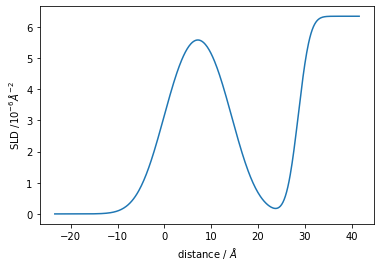

________________________________________________________________________________
Parameters: 'Structure - d2o'
________________________________________________________________________________
Parameters:      'Air'     
<Parameter: 'Air - thick' , value=0 (fixed)  , bounds=[-inf, inf]>
<Parameter:  'Air - sld'  , value=0 (fixed)  , bounds=[-inf, inf]>
<Parameter: 'Air - isld'  , value=0 (fixed)  , bounds=[-inf, inf]>
<Parameter: 'Air - rough' , value=0 (fixed)  , bounds=[-inf, inf]>
<Parameter:'Air - volfrac solvent', value=0 (fixed)  , bounds=[-inf, inf]>
________________________________________________________________________________
Parameters:      'D2O'     
<Parameter:'thickness_solution', value=14.3          , bounds=[6, 25]>
<Parameter:  'D2O - sld'  , value=6.34          , bounds=[5.35, 6.35]>
<Parameter: 'D2O - isld'  , value=0 (fixed)  , bounds=[-inf, inf]>
<Parameter:'rough_preceding_solution', value=4.6          , bounds=[0, 20]>
<Parameter:'D2O - volfrac solvent', value=0

In [7]:
# to changing to
solution_thickness = Parameter(value=14.3, bounds=(6, 25), vary=True,
            name='thickness_solution')
# solution_thickness2 = Parameter(value=14.3, bounds=(6, 25), vary=True,
#             name='thickness_solution2')

# rough_preceding_solution = Parameter(value=4.6, bounds=(0, 20), vary=True,
#             name='rough_preceding_solution')


rough_preceding_solution = Parameter(value=4.6, bounds=(0, 20), vary=True,
            name='rough_preceding_solution')#, constraint=)

dodab_thick1 = Parameter(value=14.3, bounds=(0.1, 25), vary=True,
            name='thickness_solution')
# dodab_thick2 = Parameter(value=14.3, bounds=(0.1, 25), vary=True,
#             name='thickness_solution')
firstlayer = SLD(0, "first layer")
firstlayer.real.setp(vary=True, bounds=(-1, 6.35))

structure_d2o  = air(0, 0) | d2o(solution_thickness, rough_preceding_solution)  | firstlayer(dodab_thick1, rough_preceding_solution) | d2o(solution_thickness, rough_top)
# structure_pmw  = air(0, 0) | pmw(solution_thickness1, rough_preceding_solution)  | upper_lipid_pmw  | lower_lipid_pmw  | pmw(solution_thickness2, rough_top)
# structure_acmw = air(0, 0) | dodab_acmw | acmw(solution_thickness, rough_preceding_solution) | upper_lipid_acmw | lower_lipid_acmw | acmw(solution_thickness, rough_top)

# structure_d2o  = air(0, 0) | d2o(solution_thickness, rough_preceding_solution)  | upper_lipid_d2o  | lower_lipid_d2o  | d2o(solution_thickness, rough_preceding_solution)
# structure_pmw  = air(0, 0) | pmw(solution_thickness, rough_preceding_solution)  | upper_lipid_pmw  | lower_lipid_pmw  | pmw(solution_thickness, rough_preceding_solution)
# structure_acmw = air(0, 0) | acmw(solution_thickness, rough_preceding_solution) | upper_lipid_acmw | lower_lipid_acmw | acmw(solution_thickness, rough_preceding_solution)

structure_d2o.name = "d2o"
# structure_pmw.name = "protein matched water"
# structure_acmw.name = "ACMW"

plt.plot(*structure_d2o.sld_profile(),label="structure_d2o")
plt.ylabel('SLD /$10^{-6} \AA^{-2}$')
plt.xlabel('distance / $\AA$')
# plt.plot(*structure_pmw.sld_profile(),label="structure_pmw")
# plt.ylabel('SLD /$10^{-6} \AA^{-2}$')
# plt.xlabel('distance / $\AA$')
# plt.plot(*structure_acmw.sld_profile(),label="structure_acmw")
# plt.ylabel('SLD /$10^{-6} \AA^{-2}$')
# plt.xlabel('distance / $\AA$')
plt.show();
print(structure_d2o.parameters)
# print(structure_pmw.parameters)
# print(structure_acmw.parameters)

In [8]:
# right_protrusion_d2o.parameters

In [9]:
# print(structure_acmw.slabs())
# print(structure_pmw.slabs())
# print(structure_d2o.slabs())

def logp_extra(model=None, data=None):
    returns = 0
#     if rough_top.value > thickness_heads.value:
#         returns += -np.inf
#         print("rough, thickness: ", rough_top.value, thickness_heads.value)
#     if choose==2:
#         if upper_lipid_d2o.logp() == -np.inf:
#             returns += -np.inf
    return returns


In [10]:
scale=0.5538
print(dataD2o.y.max())#, dataPmw.y.max())#, dataAcmw.y.max())
print(dataD2o.y.min())#, dataPmw.y.min())#, dataAcmw.y.min())
model1 = ReflectModel(structure_d2o)
model1.scale.setp(scale, vary=True, bounds=(0.5, 0.65))#0.25, 1)) #1./dataD2o.y.max()
if dataD2o.y.min()<0:
    d2oUpBound = dataD2o.y.min() * 0.2
    d2oLoBound = dataD2o.y.min() * 1.8
else:
    d2oUpBound = dataD2o.y.min() * 1.8
    d2oLoBound = dataD2o.y.min() * 0.2
model1.bkg.setp(dataD2o.y.min(),vary=True,bounds=(d2oLoBound, d2oUpBound))

# model2 = ReflectModel(structure_pmw)
# model2.scale.setp(scale, vary=True, bounds=(0.5, 0.65))#0.25, 1))#(1./dataPmw.y.max(), vary=False)
# if dataPmw.y.min()<0:
#     pmwUpBound = dataPmw.y.min() * 0.2
#     pmwLoBound = dataPmw.y.min() * 1.8
# else:
#     pmwUpBound = dataPmw.y.min() * 1.8
#     pmwLoBound = dataPmw.y.min() * 0.2
# model2.bkg.setp(dataPmw.y.min(),vary=True,bounds=(pmwLoBound, pmwUpBound))

# # model3 = ReflectModel(structure_acmw)
# # model3.scale.setp(scale, vary=True, bounds=(0.5, 0.65))#0.25, 1)) #1./dataAcmw.y.max(), vary=False)
# # if dataAcmw.y.min()<0:
# #     acmwUpBound = dataAcmw.y.min() * 0.2
# #     acmwLoBound = dataAcmw.y.min() * 1.8
# # else:
# #     acmwUpBound = dataAcmw.y.min() * 1.8
# #     acmwLoBound = dataAcmw.y.min() * 0.2
# # model3.bkg.setp(dataAcmw.y.min(),vary=True,bounds=(acmwLoBound, acmwUpBound))



objective1 = Objective(model1, dataD2o, transform=Transform("logY"), logp_extra = logp_extra)
# objective2 = Objective(model2, dataPmw, transform=Transform("logY"), logp_extra =logp_extra)
# objective3 = Objective(model3, dataAcmw, transform=Transform("logY"), logp_extra =logp_extra)
# gobjective = GlobalObjective([objective1,objective2])#,objective3])

0.807
1.86e-06


In [11]:
print("")
choose=1
print("logp:",objective1.logp())
[[print(i,param.name+":",param.value, param.bounds,"logp:", param.logp())] for i,param in enumerate(objective1.varying_parameters())];
# print
# [[print(i,param)] for i,param in enumerate(gobjective.parameters)];# if "area_per_molecule" in param.name];
# gobjective.parameters
print()
# [[print(i,param.name)] for i,param in enumerate(gobjective.parameters)];# if "area" in param
list(print(p) for p in f_unique(flatten(objective1.parameters)) if "thi" in p.name or "ap" in p.name);
# upper_lipid_d2o.done()


logp: 1.1697259634694266
0 scale: 0.5538 [0.5, 0.65] logp: 1.8971199848858813
1 bkg: 1.86e-06 [3.72e-07, 3.348e-06] logp: 12.724930440993429
2 thickness_solution: 14.3 [6, 25] logp: -2.9444389791664407
3 D2O - sld: 6.34 [5.35, 6.35] logp: 0.0
4 rough_preceding_solution: 4.6 [0, 20] logp: -2.995732273553991
5 thickness_solution: 14.3 [0.1, 25] logp: -3.214867803470662
6 first layer - sld: 0.0 [-1, 6.35] logp: -1.9947003132247452
7 bilayer - roughs: 2.0 [0, 10] logp: -2.3025850929940455

<Parameter: 'Air - thick' , value=0 (fixed)  , bounds=[-inf, inf]>
<Parameter:'thickness_solution', value=14.3          , bounds=[6, 25]>
<Parameter:'thickness_solution', value=14.3          , bounds=[0.1, 25]>


In [12]:
%%time
choose = 2
if choose==0:
    fitter = CurveFitter(objective1)
    res = fitter.fit("differential_evolution", target="nlpost")#, seed=SEED)
if choose==1:
    fitter = CurveFitter(gobjective)
    fitter.sample(400)
    fitter.reset()
    res = fitter.sample(15, nthin=100)
if choose==2:
    from dynesty import DynamicNestedSampler
    from dynesty import plotting as dyplot
    from CFitter2 import CFitter
    fitter = CFitter(objective1)
    # DynamicNestedSampler
    DNSampler = DynamicNestedSampler(fitter.logl, fitter.priorTransform, fitter.nDim())
    DNSampler.run_nested(dlogz_init=0.05) # was 0.01
    res1 = DNSampler.results
    from saveDynestyRun import save_obj
    save_obj(res1, "test_results")
if choose==3:
#     import numpy as np
    from dynesty import plotting as dyplot
    from saveDynestyRun import load_obj
    res1 = load_obj("test_results")
    from dynesty.utils import quantile as _quantile
    samples = res1["samples"].T
    try:
        weights = np.exp(res1['logwt'] - res1['logz'][-1])
    except:
        weights = res1['weights']
    print(weights.shape,samples.shape)
    best = []
    for i, x in enumerate(samples):
        ql, qm, qh = _quantile(x, [0.025, 0.5, 0.975], weights=weights)
        print(ql, qm, qh, "     ", x[np.argmax(weights)])
        best.append(x[np.argmax(weights)])
        objective1.varying_parameters()[i] = x[np.argmax(weights)]
print("done")


40256it [17:21, 38.65it/s, batch: 6 | bound: 178 | nc: 1 | ncall: 154394 | eff(%): 26.074 | loglstar: -6729.450 < -6720.489 < -6723.213 | logz: -6771.883 +/-  0.428 | stop:  0.997]       


done
Wall time: 17min 22s


In [38]:
# print(gobjective.parameters,"\n++++++++++++++++++++++++++++++++++++++++++++++++++++")
fitter.logl(fitter._best)
[[print(param)] for param in objective1.parameters]#varying_parameters()]

[[print(param)] for param in objective1.varying_parameters()];

________________________________________________________________________________
Parameters: 'instrument parameters'
<Parameter:    'scale'    , value=0.649994          , bounds=[0.5, 0.65]>
<Parameter:     'bkg'     , value=1.11477e-06          , bounds=[3.72e-07, 3.348e-06]>
<Parameter:'dq - resolution', value=5 (fixed)  , bounds=[-inf, inf]>
________________________________________________________________________________
Parameters: 'Structure - d2o'
________________________________________________________________________________
Parameters:      'Air'     
<Parameter: 'Air - thick' , value=0 (fixed)  , bounds=[-inf, inf]>
<Parameter:  'Air - sld'  , value=0 (fixed)  , bounds=[-inf, inf]>
<Parameter: 'Air - isld'  , value=0 (fixed)  , bounds=[-inf, inf]>
<Parameter: 'Air - rough' , value=0 (fixed)  , bounds=[-inf, inf]>
<Parameter:'Air - volfrac solvent', value=0 (fixed)  , bounds=[-inf, inf]>
________________________________________________________________________________
Parameter

In [39]:
if choose==2 or choose==3:
    print(res1)
else:
    print(res)
# [['bkg', nan],
#  ['thickness_solution', nan],
#  ['D2O - sld', nan],
#  ['rough_preceding_solution', nan],
#  ['bilayer - area_per_molecule', nan],
#  ['bilayer - thickness_heads', nan],
#  ['bilayer - thickness_tails', nan],
#  ['bilayer - rough_top', nan],
#  ['bilayer - Waters Per Head', nan],
#  ['bilayer - Waters Per Tail', nan],
#  ['bilayer - ratio protein to bilayer', nan],
#  ['bkg', nan],
#  ['Protein Matched Water - sld', nan],
#  ['bkg', nan],
#  ['ACMW - sld', nan]]

         niter: 40256
         ncall: array([1, 1, 1, ..., 1, 1, 1])
           eff: 26.07355208103942
       samples: array([[ 5.15738190e-01,  1.30613168e-06,  1.97164755e+01, ...,
         2.16119659e+01,  3.80783537e+00,  4.23406445e-02],
       [ 5.94575957e-01,  7.53129105e-07,  2.48175158e+01, ...,
         7.72881509e+00,  2.44808705e+00,  6.44482969e+00],
       [ 5.07366767e-01,  1.13921590e-06,  7.55918948e+00, ...,
         2.37307374e+01,  3.19270244e+00,  9.76306874e+00],
       ...,
       [ 6.49989228e-01,  1.13243175e-06,  2.42716911e+01, ...,
         2.49999926e+01, -9.99995037e-01,  3.98219756e-02],
       [ 6.49999460e-01,  1.23745860e-06,  2.42761209e+01, ...,
         2.49997568e+01, -9.99993627e-01,  3.69557137e-02],
       [ 6.49993843e-01,  1.11477147e-06,  2.42969318e+01, ...,
         2.49998505e+01, -9.99986658e-01,  2.07591974e-02]])
    samples_id: array([173, 113, 239, ..., 379, 330,  93], dtype=int64)
 samples_batch: array([0, 0, 0, ..., 0, 0, 0])
    s

         scale: array([1., 1., 1., ..., 1., 1., 1.])


In [40]:
# print(structure_acmw.slabs())
# print(structure_pmw.slabs())
print(structure_d2o.slabs())

[[ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00]
 [ 2.42969318e+01  6.29541965e+00  0.00000000e+00  1.34756822e+01
   0.00000000e+00]
 [ 2.49998505e+01 -9.99986658e-01  0.00000000e+00  1.34756822e+01
   0.00000000e+00]
 [ 2.42969318e+01  6.29541965e+00  0.00000000e+00  2.07591974e-02
   0.00000000e+00]]


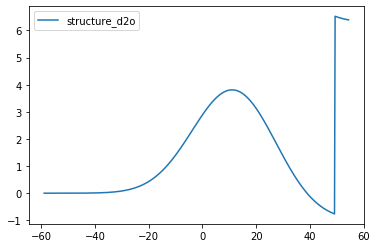

In [41]:
# structure_d2o
# structure_pmw
plt.plot(*structure_d2o.sld_profile(),label="structure_d2o")
# structure_d2o.plot()
# plt.ylabel('SLD ($10^{-6} \AA^{-2})$')
# plt.xlabel('distance  $(\AA)$')

# plt.plot(*structure_pmw.sld_profile(),label="structure_pmw")
# # structure_pmw.plot()
# plt.ylabel('SLD ($10^{-6} \AA^{-2})$')
# plt.xlabel('distance  $(\AA)$')

# # plt.plot(*structure_acmw.sld_profile(),label="structure_acmw")
# # # structure_pmw.plot()
# # plt.ylabel('SLD ($10^{-6} \AA^{-2})$')
# # plt.xlabel('distance  $(\AA)$')
plt.legend()
plt.show();

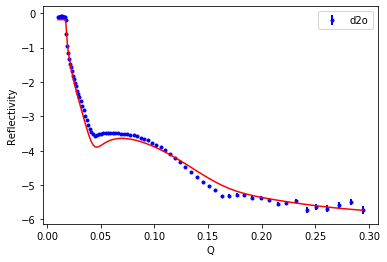

In [42]:
if choose==1:
    objective1.plot(samples=300)
else:
    objective1.plot()
# plt.yscale('log')
plt.xlabel('Q')
plt.ylabel('Reflectivity')
plt.legend();

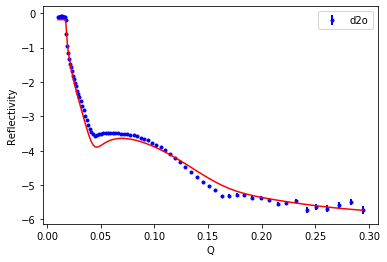

In [43]:
if choose==1:
    objective1.plot(samples=300)
else:
    objective1.plot()
# plt.yscale('log')
plt.xlabel('Q')
plt.ylabel('Reflectivity')
plt.legend();

In [44]:
# if choose==1:
#     objective2.plot(samples=300)
# else:
#     objective2.plot()
# # plt.yscale('log')
# plt.xlabel('Q')
# plt.ylabel('Reflectivity')
# plt.legend();

In [45]:
# if choose==1:
#     objective3.plot(samples=300)
# else:
#     objective3.plot()
# # plt.yscale('log')
# plt.xlabel('Q')
# plt.ylabel('Reflectivity')
# plt.legend();

In [46]:
print("model1: d2o", model1.scale, model1.bkg)
# print("model2: pmw", model2.scale, model2.bkg)
# print("model3: acmw", model3.scale, model3.bkg)

model1: d2o <Parameter:    'scale'    , value=0.649994          , bounds=[0.5, 0.65]> <Parameter:     'bkg'     , value=1.11477e-06          , bounds=[3.72e-07, 3.348e-06]>


In [47]:
# print(structure_d2o)

In [48]:
# print(structure_pmw)

In [49]:
# print(structure_acmw)

In [50]:
print(structure_d2o.slabs())

[[ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00]
 [ 2.42969318e+01  6.29541965e+00  0.00000000e+00  1.34756822e+01
   0.00000000e+00]
 [ 2.49998505e+01 -9.99986658e-01  0.00000000e+00  1.34756822e+01
   0.00000000e+00]
 [ 2.42969318e+01  6.29541965e+00  0.00000000e+00  2.07591974e-02
   0.00000000e+00]]


In [51]:
# print(structure_pmw.slabs())

In [52]:
# print(structure_acmw.slabs())

C:\Users\John\Anaconda3\envs\refnx\lib\site-packages\dynesty\plotting.py:245: UserWarning: Attempting to set identical bottom == top == 0.0 results in singular transformations; automatically expanding.
  axes[i].set_ylim([ymin, ymax])


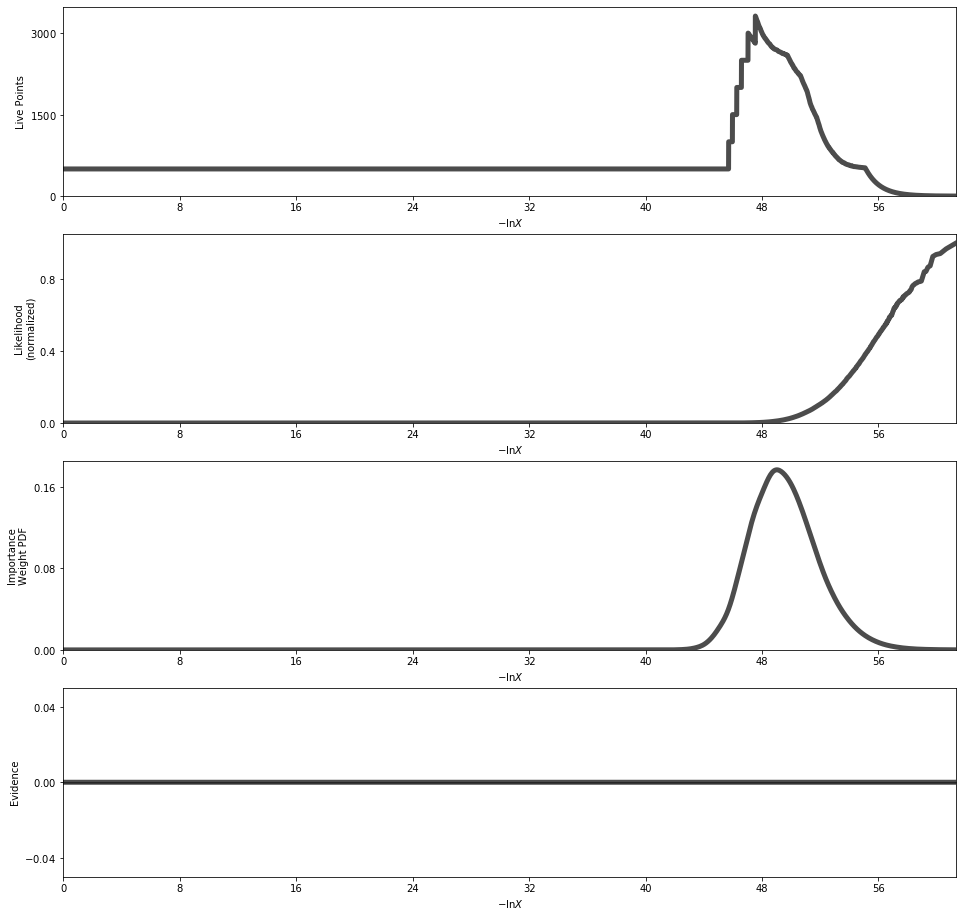

In [53]:
if choose==2 or choose==3:
    # span = [(0,5000),(0,1.5),(0,0.4),(-10**3,10**3)] #span=span
    fig, axes = dyplot.runplot(res1, color='black', mark_final_live=False,
                               logplot=False)

In [54]:
if choose==2 or choose==3:
    print("max(-ln(X)) =", -min(res1["logvol"])) # -min(res1["logvol"] = max(-ln(X))
    print("max(logz), evidence =", max(res1["logz"]))

max(-ln(X)) = 61.34249783025718
max(logz), evidence = -6771.877309368717


In [55]:
#gobjective.varying_parameters()
print("logp:",objective1.logp())
print("logpost:",objective1.logpost())
print("model1: d2o", model1.scale, model1.bkg)
# print("model2: pmw", model2.scale, model2.bkg)
# print("model3: acmw", model3.scale, model3.bkg)
print()
# [[print(i,param.name+":",param.value, param.bounds)] for i,param in enumerate(gobjective.varying_parameters())];
[[print(i,param.name+":",param.value, param.bounds,"logp:", param.logp())] for i,param in enumerate(objective1.varying_parameters())];
print()
# list(print(p) for p in f_unique(flatten(gobjective.parameters)) if "thi" in p.name or "ap" in p.name);
# volfrac_head = dodab_d2o.vm_heads.value / (dodab_d2o.apm.value *
#                                  dodab_d2o.thickness_heads.value)
# volfrac_tail = dodab_d2o.vm_tails.value / (dodab_d2o.apm.value *
#                                  dodab_d2o.thickness_tails.value)
# print("volfrac_head:",volfrac_head,"volfrac_tail:", volfrac_tail)

volfrac_head = upper_lipid_d2o.vm_heads.value / (upper_lipid_d2o.apm.value *
                                 upper_lipid_d2o.thickness_heads.value)
volfrac_tail = upper_lipid_d2o.vm_tails.value / (upper_lipid_d2o.apm.value *
                                 upper_lipid_d2o.thickness_tails.value)
print("volfrac_head:",volfrac_head,"volfrac_tail:", volfrac_tail)

logp: 1.1697259634694266
logpost: -6718.937456936874
model1: d2o <Parameter:    'scale'    , value=0.649994          , bounds=[0.5, 0.65]> <Parameter:     'bkg'     , value=1.11477e-06          , bounds=[3.72e-07, 3.348e-06]>

0 scale: 0.6499938429076382 [0.5, 0.65] logp: 1.8971199848858813
1 bkg: 1.1147714693089718e-06 [3.72e-07, 3.348e-06] logp: 12.724930440993429
2 thickness_solution: 24.29693177114767 [6, 25] logp: -2.9444389791664407
3 D2O - sld: 6.295419650190357 [5.35, 6.35] logp: 0.0
4 rough_preceding_solution: 13.47568216902911 [0, 20] logp: -2.995732273553991
5 thickness_solution: 24.99985052408875 [0.1, 25] logp: -3.214867803470662
6 first layer - sld: -0.9999866581870958 [-1, 6.35] logp: -1.9947003132247452
7 bilayer - roughs: 0.02075919735112612 [0, 10] logp: -2.3025850929940455

volfrac_head: 1.1033333333333333 volfrac_tail: 1.7094545454545456


logp: -56.146584793369705\
logpost: -77.9396189655922\
model1: d2o <Parameter:    'scale'    , value=0.549959 +/- 0.00156, bounds=[0.5, 0.65]> <Parameter:     'bkg'     , value=1.53912e-06 +/- 6.55e-07, bounds=[3.6e-07, 3.24e-06]>\
model2: pmw <Parameter:    'scale'    , value=0.622856 +/- 0.0327, bounds=[0.5, 0.65]> <Parameter:     'bkg'     , value=3.16464e-06 +/- 1.1e-07, bounds=[6.040000000000001e-07, 5.436e-06]>\
model3: acmw <Parameter:    'scale'    , value=0.500619 +/- 0.0736, bounds=[0.5, 0.65]> <Parameter:     'bkg'     , value=2.48673e-06 +/- 6.89e-08, bounds=[3.46e-07, 3.114e-06]>

0 scale: 0.5499586401401358 [0.5, 0.65] logp: 1.8971199848858813\
1 bkg: 1.5391212486873202e-06 [3.6e-07, 3.24e-06] logp: 12.75772026381642\
2 mono, dodab - area_per_molecule: 119.65320429338891 [30, 120] logp: -4.499809670330265\
3 mono, dodab - thickness heads: 1.036008140446489 [1, 30] logp: -3.367295829986474\
4 mono, dodab - thickness_tails: 29.8460144476636 [1, 30] logp: -3.367295829986474\
5 mono, dodab - roughness: 4.3064597599418 [0, 10] logp: -2.3025850929940455\
6 D2O - sld: 6.112155832681692 [5.35, 6.35] logp: 0.0\
7 thickness_solution: 7.054386692871898 [6, 25] logp: -2.9444389791664407\
8 rough_preceding_solution: 0.46360628020685724 [0, 20] logp: -2.995732273553991\
9 bilayer - area_per_molecule: 56.37095281850116 [25, 100] logp: -4.31748811353631\
10 bilayer - thickness_heads: 9.088112327401571 [1, 30] logp: -3.367295829986474\
11 bilayer - thickness_tails: 16.68072511918294 [1, 30] logp: -3.367295829986474\
12 bilayer - roughs: 6.149987663530782 [0, 10] logp: -2.3025850929940455\
13 bilayer - ratio protein to bilayer: 0.9996470312154738 [0, 1] logp: 0.0\
14 scale: 0.6228561118432872 [0.5, 0.65] logp: 1.8971199848858813\
15 bkg: 3.1646423878640438e-06 [6.040000000000001e-07, 5.436e-06] logp: 12.24025009733176\
16 Protein Matched Water - sld: 1.7014884935917003 [1.35, 3.35] logp: -0.6931471805599453\
17 scale: 0.5006187267684357 [0.5, 0.65] logp: 1.8971199848858813\
18 bkg: 2.486729606390888e-06 [3.46e-07, 3.114e-06] logp: 12.79738552020885\
19 ACMW - sld: 0.3978678671938674 [-0.56, 1] logp: -0.4446858212614458\

volfrac_head: 0.440458647988677 volfrac_tail: 0.2792361178637983\
volfrac_head: 0.6460987963405301 volfrac_tail: 0.9998847519862003

logp: -61.837944748027354\
logpost: -106.91571614664562\
model1: d2o <Parameter:    'scale'    , value=0.5538 (fixed)  , bounds=[0.5, 0.65]> <Parameter:     'bkg'     , value=1.42723e-06 +/- 5.42e-07, bounds=[3.6e-07, 3.24e-06]>\
model2: pmw <Parameter:    'scale'    , value=0.5538 (fixed)  , bounds=[0.5, 0.65]> <Parameter:     'bkg'     , value=3.16231e-06 +/- 1.17e-07, bounds=[6.040000000000001e-07, 5.436e-06]>\
model3: acmw <Parameter:    'scale'    , value=0.5538 (fixed)  , bounds=[0.5, 0.65]> <Parameter:     'bkg'     , value=2.33864e-06 +/- 8.66e-08, bounds=[3.46e-07, 3.114e-06]>

0 bkg: 1.4272281344919903e-06 [3.6e-07, 3.24e-06] logp: 12.75772026381642\
1 mono, dodab - area_per_molecule: 119.3104661757678 [30, 120] logp: -4.499809670330265\
2 mono, dodab - thickness heads: 1.003788411352005 [1, 30] logp: -3.367295829986474\
3 mono, dodab - thickness_tails: 8.459530497241362 [1, 30] logp: -3.367295829986474\
4 mono, dodab - roughness: 4.726381250286709 [0, 10] logp: -2.3025850929940455
5 D2O - sld: 6.102171630940265 [5.35, 6.35] logp: 0.0\
6 thickness_solution: 6.005305558368871 [6, 25] logp: -2.9444389791664407\
7 rough_preceding_solution: 0.7033365541873842 [0, 20] logp: -2.995732273553991\
8 bilayer - area_per_molecule: 56.57248121276474 [25, 100] logp: -4.31748811353631\
9 bilayer - thickness_heads: 10.404361863977677 [1, 30] logp: -3.367295829986474\
10 bilayer - thickness_tails: 16.62073579505735 [1, 30] logp: -3.367295829986474\
11 bilayer - roughs: 5.632005175040831 [0, 10] logp: -2.3025850929940455\
12 bilayer - ratio protein to bilayer: 0.9989985048553018 [0, 1] logp: 0.0\
13 bkg: 3.1623081408563898e-06 [6.040000000000001e-07, 5.436e-06] logp: 12.24025009733176\
14 Protein Matched Water - sld: 1.7739516476811712 [1.35, 3.35] logp: -0.6931471805599453\
15 bkg: 2.3386377143800643e-06 [3.46e-07, 3.114e-06] logp: 12.79738552020885\
16 ACMW - sld: 0.40434141975494714 [-0.56, 1] logp: -0.4446858212614458\

volfrac_head: 0.45590244635432514 volfrac_tail: 0.9880011880120377\
volfrac_head: 0.5623508013321004 volfrac_tail: 0.9999188924455843

In [31]:
print(#upper_lipid_d2o.total_vm(),"\n",
# upper_lipid_d2o.sld_r(),"\n",
float(upper_lipid_d2o.b_heads_real) / float(upper_lipid_d2o.vm_heads.value) * 1.e6,"\n",
float(upper_lipid_d2o.b_tails_real) / float(upper_lipid_d2o.vm_tails.value) * 1.e6,"\n",
upper_lipid_d2o.b_heads_real,"\n",
upper_lipid_d2o.b_tails_real,"\n")#,
# float(dodab_d2o.b_heads_real) / float(dodab_d2o.vm_heads.value) * 1.e6,"\n",
# float(dodab_d2o.b_tails_real) / float(dodab_d2o.vm_tails.value) * 1.e6,"\n",
# dodab_d2o.b_heads_real,"\n",
# dodab_d2o.b_tails_real,"\n")#,
# upper_lipid_d2o.protien_frac_in_head(),"\n",
# upper_lipid_d2o.protien_frac_in_tail(),"\n",
# upper_lipid_d2o.vm_head(),"\n",
# upper_lipid_d2o.vm_tail(),"\n",
# upper_lipid_d2o.vm_heads,"\n",
# upper_lipid_d2o.vm_tails,"\n",
# upper_lipid_d2o.PLRatio,"\n",
# upper_lipid_d2o.vm_mscl,"\n")
# upper_lipid_d2o.total_vm(),"\n")

1.9011329305135953 
 -0.28317379281004046 
 <Parameter:'bilayer - b_heads_real', value=0.000629275 (fixed)  , bounds=[-inf, inf]> 
 <Parameter:'bilayer - b_tails_real', value=-0.00026624 (fixed)  , bounds=[-inf, inf]> 



In [35]:
fitter._bestPost, fitter._best

(-6718.937456936874,
 array([ 6.49993843e-01,  1.11477147e-06,  2.42969318e+01,  6.29541965e+00,
         1.34756822e+01,  2.49998505e+01, -9.99986658e-01,  2.07591974e-02]))

<!-- I believe correct values, leaflet roughness between head and tail is the same as the roughness preceeding the leaflet\
class used is a modified version of the LipidLeaflet class native to refnx, its in the file\
"protein" and called "LipidLeafletWithProtien"\
volumes of head and tails are indirectly varied by changes in waters per head/tail\
so the tails do not change volume\
0 scale: 0.5521883304658243 [0.5, 0.6]\
1 bkg: 3.8668280301251303e-07 [3.6e-07, 3.24e-06]\
2 thickness_solution: 10.788185214150985 [6, 25]\
3 D2O - sld: 6.120774383877097 [5.35, 6.35]\
4 rough_preceding_solution: 3.939327435493368 [0, 20]\
5 bilayer - area_per_molecule: 149.83843268748353 [60, 150]\
6 bilayer - thickness_heads: 2.2131024442953855 [1, 30]\
7 bilayer - thickness_tails: 19.19114563662231 [1, 30]\
8 bilayer - rough_top: 0.15555337800548585 [0, 10]\
9 bilayer - Waters Per Head: 0.017922237590786594 [0, 20]\
10 bilayer - Waters Per Tail: 0.02927203409960022 [0, 10]\
11 bilayer - ratio protein to bilayer: 0.7498017765068212 [0.25, 0.75]\
12 Protrusion - protrusion thickness: 6.090177488208205 [5, 100]\
13 Protrusion - protrusion roughness: 7.445463122283828 [0, 20]\
14 Protrusion - protrusion volfrac: 0.9963095809664922 [0, 1]\
15 scale: 0.5990025735918081 [0.5, 0.6]\
16 bkg: 3.5880504074107574e-06 [6.040000000000001e-07, 5.436e-06]\
17 Protein Matched Water - sld: 1.757984633375042 [1.35, 3.35]\
18 scale: 0.5907367476195101 [0.5, 0.6]\
19 bkg: 2.831535701386751e-06 [3.46e-07, 3.114e-06]\
20 ACMW - sld: 0.4132210895757328 [-0.56, 1] -->

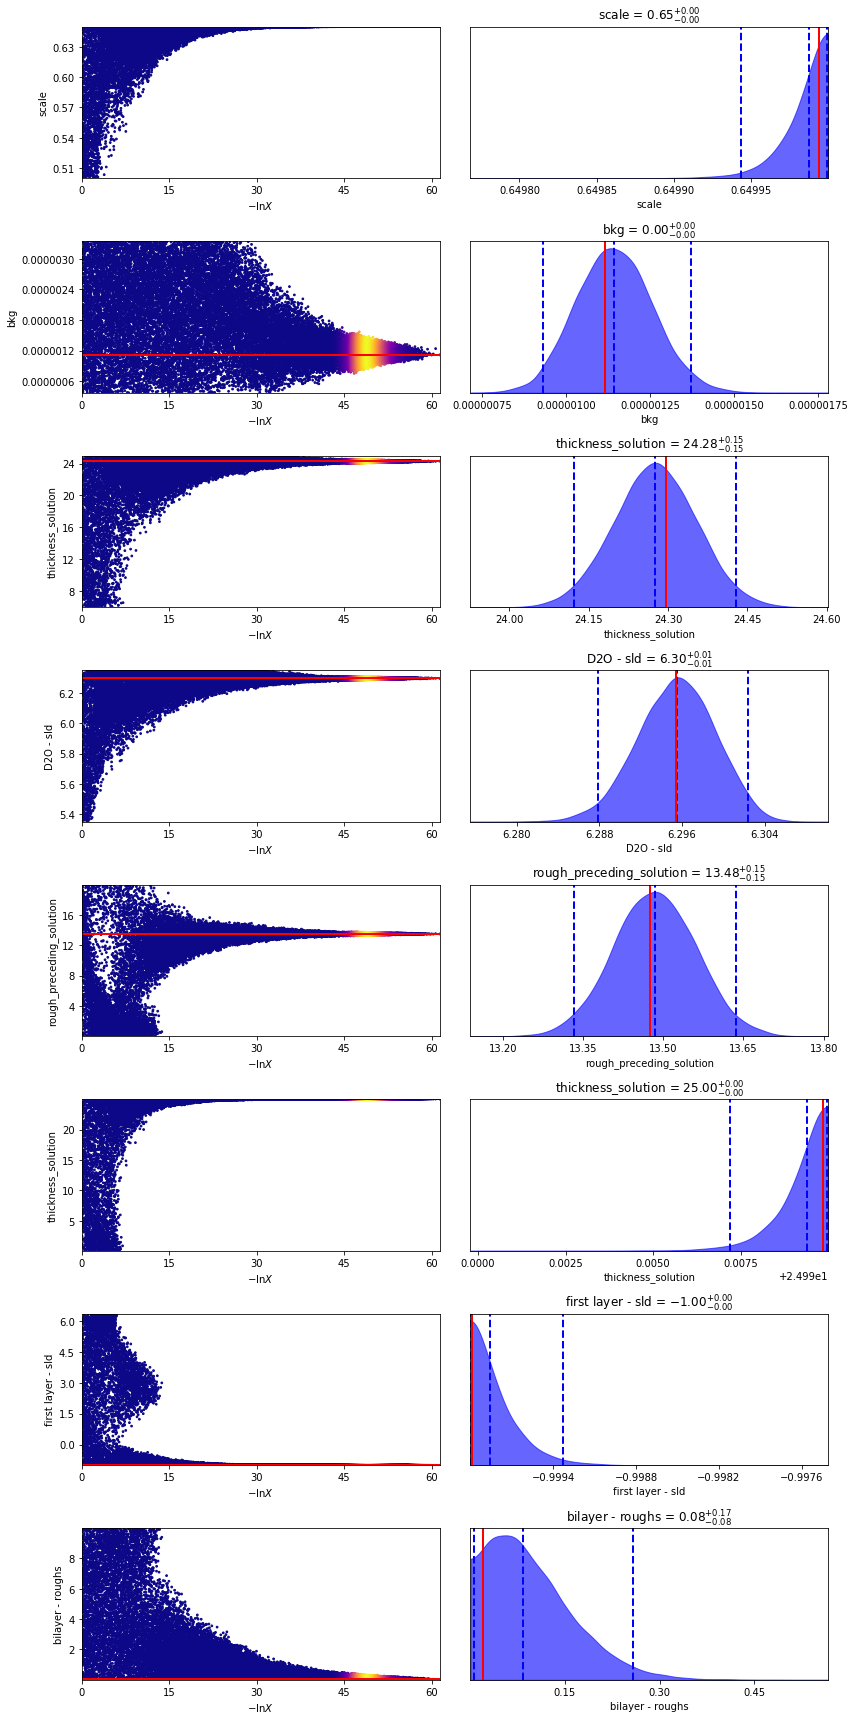

In [36]:
if choose==2 or choose==3:
    labels = [param.name for param in objective1.varying_parameters()]

    fig, axes = dyplot.traceplot(res1, labels = labels, truths=fitter._best,#np.zeros(fitter.nDim()),
                                 show_titles=True, trace_cmap='plasma',
                                 quantiles=[0.025, 0.5, 0.975])
    fig.tight_layout()

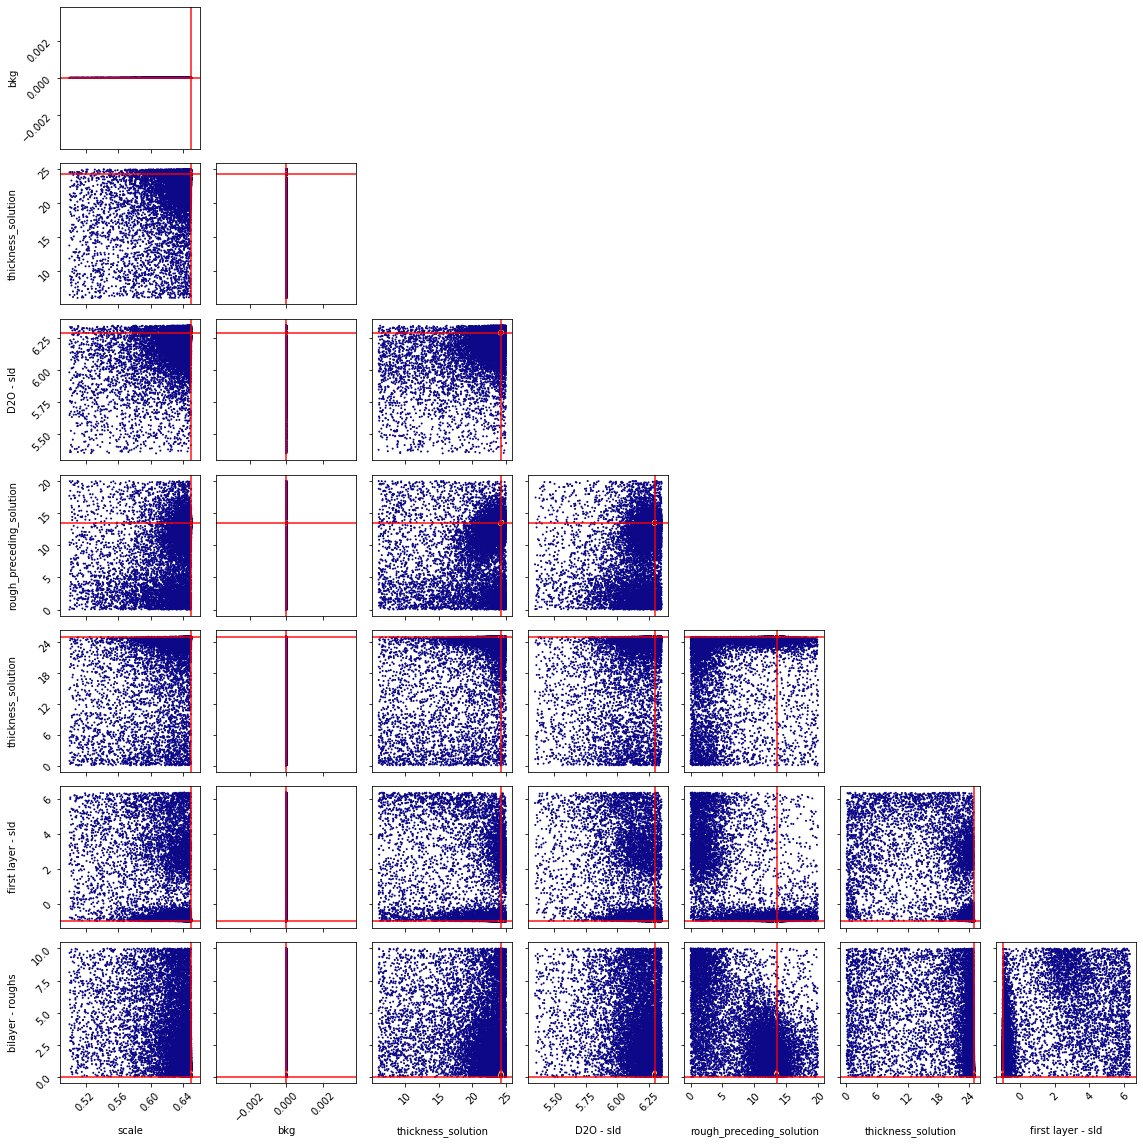

In [37]:
if choose==2 or choose==3:
    labels = [param.name for param in objective1.varying_parameters()]

    fig, axes = dyplot.cornerpoints(res1, labels = labels, truths=fitter._best,#, #truths=np.zeros(fitter.nDim()),
                                 #show_titles=True,
                                 #trace_cmap='plasma',
                                 #quantiles=[0.025, 0.5, 0.975]
                                   )
    fig.tight_layout()

In [ ]:
# # from saveDynestyRun import save_obj, load_obj
# # save_obj(res1, "test_results")
# # res2 = load_obj("test_results")
# if choose==2 or choose==3:
#     labels = [param.name for param in objective1.varying_parameters()]

#     fig, axes = dyplot.cornerpoints(res2, labels = labels#, #truths=np.zeros(fitter.nDim()),
#                                  #show_titles=True,
#                                  #trace_cmap='plasma',
#                                  #quantiles=[0.025, 0.5, 0.975]
#                                    )
#     fig.tight_layout()